In [20]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.nn.functional import binary_cross_entropy

from sklearn.model_selection import train_test_split

In [3]:
data = MNIST(root='datasets', download=True, transform = ToTensor())

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

print(data[0][0].shape)

torch.Size([1, 28, 28])


# AutoEncoder

In [12]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 32)
        self.fc4 = torch.nn.Linear(32, output_size)
        self.relu = torch.nn.ReLU()
        self.droupout = torch.nn.Dropout(0.3)

    def forward(self, x): 
        # x: batch_size, 1, input_size
        # output: batch_size, output_size
        x = self.relu(self.fc1(x))
        x = self.droupout(x)
        x = self.relu(self.fc2(x))
        x = self.droupout(x)
        x = self.relu(self.fc3(x))
        x = self.droupout(x)
        x = self.relu(self.fc4(x))
        return x
    
class Decoder(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(input_size, 32)
        self.fc2 = torch.nn.Linear(32, 64)
        self.fc3 = torch.nn.Linear(64, 128)
        self.fc4 = torch.nn.Linear(128, output_size)
        self.relu = torch.nn.ReLU()
        self.droupout = torch.nn.Dropout(0.3)

    def forward(self, x):
        # x: batch_size, input_size
        # output: batch_size, output_size
        x = self.relu(self.fc1(x))
        x = self.droupout(x)
        x = self.relu(self.fc2(x))
        x = self.droupout(x)
        x = self.relu(self.fc3(x))
        x = self.droupout(x)
        x = self.relu(self.fc4(x))
        return x


class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_size, 32)
        self.decoder = Decoder(32, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
ae = AutoEncoder(28*28)
summary(ae, input_size=(32, 1, 28 * 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 1, 784]              --
├─Encoder: 1-1                           [32, 1, 32]               --
│    └─Linear: 2-1                       [32, 1, 128]              100,480
│    └─ReLU: 2-2                         [32, 1, 128]              --
│    └─Dropout: 2-3                      [32, 1, 128]              --
│    └─Linear: 2-4                       [32, 1, 64]               8,256
│    └─ReLU: 2-5                         [32, 1, 64]               --
│    └─Dropout: 2-6                      [32, 1, 64]               --
│    └─Linear: 2-7                       [32, 1, 32]               2,080
│    └─ReLU: 2-8                         [32, 1, 32]               --
│    └─Dropout: 2-9                      [32, 1, 32]               --
│    └─Linear: 2-10                      [32, 1, 32]               1,056
│    └─ReLU: 2-11                        [32, 1, 32]               --
├

In [13]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

n_epochs = 50
train_loss = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae.to(device)

for epoch in range(n_epochs):
    running_loss = 0.0
    for idx, (imag, label) in enumerate(train_dataloader):
        imag = imag.view(imag.size(0), -1)
        imag = imag.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs = ae(imag)
        loss = criterion(outputs, imag)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss = running_loss / len(train_dataloader)
    train_loss.append(loss)
    print(f'Epoch {epoch+1}: loss {loss}')


Epoch 1: loss 0.06135228997717301
Epoch 2: loss 0.05229504263152679
Epoch 3: loss 0.04976877938210964
Epoch 4: loss 0.048440256021916865
Epoch 5: loss 0.047540292496482534
Epoch 6: loss 0.046971997474630676
Epoch 7: loss 0.046538374294837315
Epoch 8: loss 0.04597497732192278
Epoch 9: loss 0.045791570104658605
Epoch 10: loss 0.04556980454425017
Epoch 11: loss 0.045391848313311736
Epoch 12: loss 0.04509322161475817
Epoch 13: loss 0.04494677977015575
Epoch 14: loss 0.04493106800566117
Epoch 15: loss 0.044746972347299255
Epoch 16: loss 0.044701680228114125
Epoch 17: loss 0.04461798253407081
Epoch 18: loss 0.0445616112301747
Epoch 19: loss 0.044460710478325685
Epoch 20: loss 0.04437869024525086
Epoch 21: loss 0.044301267000536125
Epoch 22: loss 0.04425190952171882
Epoch 23: loss 0.044171457529067995
Epoch 24: loss 0.044284958921372894
Epoch 25: loss 0.04416575222710768
Epoch 26: loss 0.04410568370173375
Epoch 27: loss 0.04407625983158747
Epoch 28: loss 0.044029526884357136


KeyboardInterrupt: 

In [16]:
ae.eval()

outputs = []
inputs = []
for idx, (imag, label) in enumerate(test_dataloader):
    image = imag.view(imag.size(0), -1)
    image = image.to(device)
    output = ae(image)
    inputs.append(image.detach().cpu())
    outputs.append(output.detach().cpu())

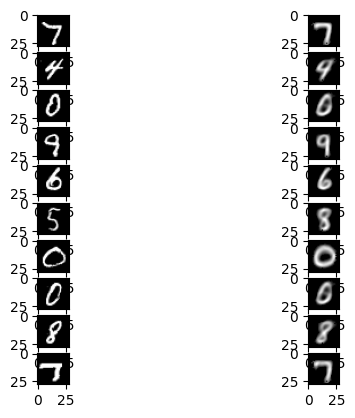

In [17]:
fig, axs = plt.subplots(10,2)
for i in range(10):
    # print(inputs[i].shape)
    axs[i, 0].imshow(inputs[i][0].view(28, 28), cmap='gray')
    axs[i, 1].imshow(outputs[i][0].view(28, 28), cmap='gray')
plt.show()

# VAE

In [23]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size) # -> mu
        self.fc3 = torch.nn.Linear(hidden_size, output_size) # -> log(var)
        self.relu = torch.nn.ReLU()
        self.droupout = torch.nn.Dropout(0.3)

    def forward(self, x): 
        x = self.relu(self.fc1(x))
        x = self.droupout(x)
        mu = self.relu(self.fc2(x))
        logvar = self.relu(self.fc3(x))
        return mu, logvar
        
class Decoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.droupout = torch.nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.droupout(x)
        x = self.sigmoid(self.fc2(x))
        return x


class VAE(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, output_size)
        self.decoder = Decoder(output_size, hidden_size, input_size)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x = self.decoder(z)
        return x, mu, logvar
    
vae = VAE(28*28, 512, 64)
summary(vae, input_size=(32, 1, 28 * 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 784]              --
├─Encoder: 1-1                           [32, 1, 64]               --
│    └─Linear: 2-1                       [32, 1, 512]              401,920
│    └─ReLU: 2-2                         [32, 1, 512]              --
│    └─Dropout: 2-3                      [32, 1, 512]              --
│    └─Linear: 2-4                       [32, 1, 64]               32,832
│    └─ReLU: 2-5                         [32, 1, 64]               --
│    └─Linear: 2-6                       [32, 1, 64]               32,832
│    └─ReLU: 2-7                         [32, 1, 64]               --
├─Decoder: 1-2                           [32, 1, 784]              --
│    └─Linear: 2-8                       [32, 1, 512]              33,280
│    └─ReLU: 2-9                         [32, 1, 512]              --
│    └─Dropout: 2-10                     [32, 1, 512]              -

In [25]:
def loss_VAE(x, x_hat, mu, logvar):
    KL = 0.5 * torch.sum(-logvar + torch.exp(logvar) + mu**2 - 1)
    BCE = binary_cross_entropy(x_hat, x, reduction='sum')
    return KL + BCE

criterion = loss_VAE
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)

n_epochs = 50
train_loss = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae.to(device)
vae.train()

for epoch in range(n_epochs):
    running_loss = 0.0
    for idx, (image, label) in enumerate(train_dataloader):
        image = image.view(image.size(0), -1)
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        outputs, mu, logvar = vae(image)
        loss = criterion(image, outputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss = running_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}: loss {loss}')
    train_loss.append(loss)
    


Epoch 1: loss 17632.373334635417
Epoch 2: loss 17632.973559895832
Epoch 3: loss 17631.525518229166
Epoch 4: loss 17632.9154609375


KeyboardInterrupt: 